# The Traveling Salesperson Problem

Consider the [*Traveling Salesperson Problem*](http://en.wikipedia.org/wiki/Traveling_salesman_problem) (or TSP): 

> *Given a set of cities and the distance between each pair of cities, what is the shortest possible tour that visits each city exactly once, and returns to the starting city?*

In this notebook we will develop some solutions to the problem, and more generally show *how to think about* solving  problems. The algorithms developed here are used in [serious applications](https://research.googleblog.com/2016/09/the-280-year-old-algorithm-inside.html) that millions of people rely on every day.

|![](http://support.sas.com/documentation/cdl/en/ornoaug/66084/HTML/default/images/map002g.png)|
|---|
|[An example tour](http://www.math.uwaterloo.ca/tsp/history/pictorial/dfj.html)|

Do we understand the problem statement well enough to program a solution? Let's check:

- ***Given a set of cities***
<br>A Python `set` could represent a set of cities. An individual city might be just an integer index, or it might be (x, y) coordinates.
- ... ***and the distance between each pair of cities***: 
<br>We could use either a function, `distance(A, B),` or a table, `distance[A, B]`.
- ... ***what is the shortest possible tour***
<br>A tour is a sequential order in which to visit the cities; a function `shortest_tour(tours)` should find the one that minimizes `tour_length(tour)`, which is the sum of the distances between adjacent cities in the tour. 
- ... ***that visits each city once and returns to the starting city***
<br>Make sure a tour doesn't re-visit a city (except returning to the start). 



I don't yet have all the answers, but I'm ready to attack the problem. 

In [ ]:
# Imports used in this notebook. This is Python 3 on Jupyter with matplotlib.
%matplotlib inline
import matplotlib.pyplot as plt
import random
from time        import clock 
from itertools   import permutations, combinations
from functools   import lru_cache as cache
from collections import Counter
from statistics  import mean, median

# Exhaustive Search Algorithm: `exhaustive_tsp`

Let's start with an algorithm that is *guaranteed* to solve the problem, although inefficiently:

> **Exhaustive Search Algorithm**: *Generate all possible tours of the cities, and choose the shortest tour (the one with minimum tour length).*

My design philosophy is to first write an English description of the algorithm (as above), then write Python code that closely mirrors the English description. This will probably require some auxilliary functions and data structures; just assume they exist; put them on a TO DO list, and eventually define them with the same design philosophy:

In [ ]:
def exhaustive_tsp(cities):
    "Generate all possible tours of the cities and choose the shortest tour."
    return shortest_tour(alltours(cities))

def shortest_tour(tours): return min(tours, key=tour_length)

# TO DO: Data types: City, Cities, Tour; Functions: alltours, tour_length

This gives us a good start; the Python code closely matches the English description.  Now for the TO DO list.

**Tours:** A tour that starts in city `1`, moves to `2`, then `3`, then back to `1` will be represented by  `(1, 2, 3)`. Any valid tour of a set of cities will be a *permutation* of the cities. That means we can implement `alltours` with the built-in `permutations` function (from the `itertools` module). 
The length of a tour is the sum of the distances between adjacent cities in the tour&mdash;the sum of the lengths of the **links** between cities in the tour. 

**Cities:** the only thing we need to know about a city is its distance to other cities. We don't need to know the city's name, population, best restaurants, or anything else.  We'll assume the distance between two cities is the [Euclidean distance](http://en.wikipedia.org/wiki/Euclidean_distance), the straight-line distance between points in a two-dimensional plane. So I want `City(300, 100)` to be the city with x-coordinate 300 and y coordinate 100. At first glance it seems like Python does not have a builtin type for a point in the two-dimensional plane, but actually there is one: complex numbers. I'll implement `City` with `complex`, which means the distance between two cities, `distance(A, B)`, is the absolute value of the vector difference between them. 
I'll also define `Cities(n)` to make a set of `n` random cities. I want `Cities(n)` to be reproducible (to return the same result when called with the same arguments), so I provide an optional argument that sets `random.seed`. 

In [ ]:
alltours = permutations 

def tour_length(tour):
    """The total of distances between each pair of consecutive cities in the tour.
    This includes the last-to-first, distance(tour[-1], tour[0])"""
    return sum(distance(tour[i - 1], tour[i]) 
               for i in range(len(tour)))

City = complex

def distance(A, B): return abs(A - B)

def Cities(n, seed=123, width=999, height=666):
    "Make a set of n cities, sampled uniformly from a (width x height) rectangle."
    random.seed((n, seed))
    return frozenset(City(random.randint(1, width), random.randint(1, height))
                     for c in range(n))

# A solution!

Now we're ready: `exhaustive_tsp` can find a tour for a set of cities:

In [ ]:
exhaustive_tsp(Cities(10))

((2+557j),
 (564+539j),
 (603+568j),
 (812+511j),
 (805+473j),
 (951+356j),
 (716+194j),
 (732+83j),
 (334+236j),
 (42+58j))

Quick, is that the shortest tour?  I can't tell. But this should help:

## Visualizing results: `plot_tour` and `do`


In [ ]:
def plot_tour(tour, style='bo-'): 
    "Plot every city and link in the tour, and highlight start city."
    if len(tour) > 1000: plt.figure(figsize=(15, 10))
    start = tour[0:1]
    plot_segment(tour + start, style)
    plot_segment(start, 'rD') # start city is red Diamond.
    
def plot_segment(segment, style='bo-'):
    "Plot every city and link in the segment."
    plt.plot([X(c) for c in segment], [Y(c) for c in segment], style, clip_on=False)
    plt.axis('scaled')
    plt.axis('off')
    
def X(city): "X coordinate."; return city.real
def Y(city): "Y coordinate."; return city.imag

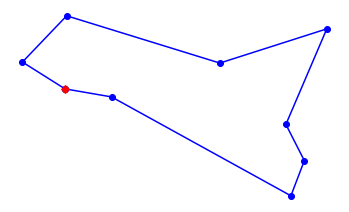

In [ ]:
plot_tour(exhaustive_tsp(Cities(9)))

That looks much better!  It certainly looks like the shortest possible tour, although I can't prove it. 

*Vocabulary note:* A **segment** is a portion of a tour that does not loop back to the start. The **segment** `(1, 2, 3)` has only two links, 1-2 and 2-3, whereas the **tour** `(1, 2, 3)` has three links, because it includes the link back to the start, 3-1.

One more convenience: the function `do` runs a TSP algorithm on a set of cities, plots the tour, asserts it is valid, and prints summary information. 

In [ ]:
def do(algorithm, cities):
    "Apply a TSP algorithm to cities, plot the result, and print info."
    t0   = clock()
    tour = algorithm(cities)
    t1   = clock()
    assert Counter(tour) == Counter(cities) # Every city appears exactly once in tour
    plot_tour(tour)
    print("{}: {} cities ⇒ tour length {:.0f} (in {:.3f} sec)".format(
          name(algorithm), len(tour), tour_length(tour), t1 - t0))
    
def name(algorithm): return algorithm.__name__.replace('_tsp', '')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  This is separate from the ipykernel package so we can avoid doing imports until


exhaustive: 9 cities ⇒ tour length 2450 (in 1.310 sec)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  """


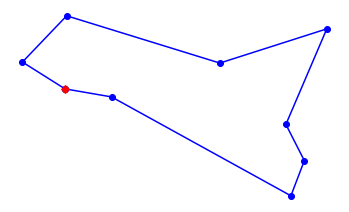

In [ ]:
do(exhaustive_tsp, Cities(9))

## Optimization: non-redundant  `alltours`

We said there are *n*! tours of *n* cities, and thus 6 tours of 3 cities:

In [ ]:
list(alltours({1, 2, 3}))

[(1, 2, 3), (1, 3, 2), (2, 1, 3), (2, 3, 1), (3, 1, 2), (3, 2, 1)]

But this is redundant: `(1, 2, 3)`, `(2, 3, 1)`, and `(3, 1, 2)` are three ways of describing the same tour. So let's arbitrarily say that a tour must start with the first city in the set of cities.  While we're redefining `alltours`, we'll take the opportunity to define a tour as a *list* rather than a *tuple*. It doesn't matter now, but I anticipate wanting to represent *partial* tours, to which we will append cities one by one; appending can be done to lists, but not tuples.

In [ ]:
def alltours(cities):
    "Return a list of non-redundant tours (permutations of cities)."
    start, *others = cities
    return [[start] + Tour(perm) for perm in permutations(others)]
    
Tour = list  # A Tour is a list of cities

We can verify that for 3 cities there are now only 2 tours, and that `exhaustive_tsp` can now do 10 cities in about the time it took to do 9 before:

In [ ]:
alltours({1, 2, 3})

[[1, 2, 3], [1, 3, 2]]

exhaustive: 10 cities ⇒ tour length 2720 (in 1.466 sec)


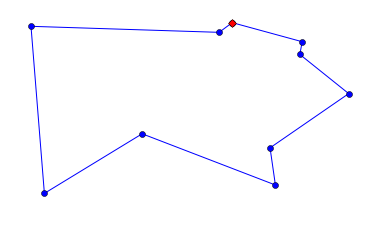

In [ ]:
do(exhaustive_tsp, Cities(10))

# General Strategies

It takes Exhaustive Search 1 or 2 seconds to solve a 10-city problem. Since it looks at all permutations, an 11-city problem would take about 11 times longer, and a 15-city problem would take days.
There must be a better way ... 

To get inspired, here are some general  strategies for algorithm design: 

* **Brute Force Strategy**: The strategy used for `exhaustive_tsp`; as [Ken Thompson](https://en.wikipedia.org/wiki/Ken_Thompson) [says](https://www.brainyquote.com/quotes/ken_thompson_185574?src=t_brute_force), *"when in doubt, use brute force."*
* **Approximation Strategy**: If it is too hard to find a precise, optimal solution, consider finding an approximate, suboptimal solution.
* **Greeedy Strategy**: To complete a multiple step problem, first do the step that has the best gain. Repeat. 
* **Iterative Improvement Strategy**: Use an existing algorithm to create a solution, then have another algorithm improve the solution.
* **Ensemble Strategy**: Apply a set of algorithms to the problem, and pick the best solution. 
* **Divide and Conquer Strategy**: Split the problem in half, solve each half, and combine the two partial solutions.
* **Stand on the Shoulders of Giants Strategy**: Find out what other people have done, and copy (or modify).

Let's apply these strategies to develop some TSP algorithms.


# Nearest Neighbor Algorithm: `nn_tsp`

> **Nearest Neighbor Algorithm:** *Start at some city; at each step extend the tour by moving from the previous city to its nearest neighbor that has not yet been visited.*

This is an instance of both the **approximation strategy** and the **greedy strategy**, where we are being greedy about choosing the shortest link to a neighbor. So now, instead of considering all *n*! tours, we incrementally build a single tour. 
In  more detail:

* ***Start at some city***  (pass the start city as an argument, or if `None`, use the first city in the set)
* ***... at each step extend the tour*** (using `tour.append`)
* ***... by moving from the previous city*** (`C`)
* ***...to its nearest neighbor*** (as given by the function `nearest_neighbor`)
* ***...that has not yet been visited*** (I will maintain a set of `unvisited` cities)

In [ ]:
def nn_tsp(cities, start=None):
    """Start the tour at the given start city (default: first city); 
    at each step extend the tour by moving from the previous city 
    to its nearest neighbor that has not yet been visited."""
    C = start or first(cities)
    tour = [C]
    unvisited = set(cities - {C})
    while unvisited:
        C = nearest_neighbor(C, unvisited)
        tour.append(C)
        unvisited.remove(C)
    return tour

def first(collection): return next(iter(collection))

def nearest_neighbor(A, cities):
    "Find the city in cities that is nearest to city A."
    return min(cities, key=lambda C: distance(C, A))

In [ ]:
def nn(cities,start=None,unvisited=[],tour=[]):
  if len(tour)==0:
    unvisited=cities
    start=cities[0]
    unvisited.remove(start)
    tour=[start]
  

  init=start
  
  
  min_dist = 1000000
  for node in unvisited:
    if(min_dist> distance(init,node)):
      min_dist=distance(init,node)
      min_node=node
  unvisited.remove(min_node)

  tour.append(min_node)
  if(len(unvisited)==0):
    return tour
  tour=nn(cities,min_node,unvisited,tour)
  return(tour)
  
    


  




In [ ]:
cities_20

[]

In [ ]:
plot_tour(nn(cities_20))

IndexError: ignored

In [ ]:
def ni(cities,unvisited=[],tour=[]):
  if len(tour)==0:
    unvisited=cities
    start=cities[0]
    unvisited.remove(start)
    tour=[start]
    min_dist = 1000000
    for node in unvisited:
      if(min_dist> distance(start,node)):
        min_dist=distance(start,node)
        min_node=node
    unvisited.remove(min_node)

    tour.append(min_node)
    tour.append(start)
  




  
  
  
  min_dist = 1000000
  for node in tour:
    for point in unvisited:
      if min_dist > distance(node,point):
        min_dist=distance(node,point)
        j=node
        k=point
  ind=tour.index(j)
  if(ind==0):
    tour.insert(ind+1,k)
  elif(ind==len(tour)):
    tour.insert(ind,k)
  else:

    if(distance(tour[ind-1],k)+distance(j,k)-distance(tour[ind-1],j)<distance(tour[ind+1],k)+distance(j,k)-distance(tour[ind+1],j)):
      tour.insert(ind,k)
    else:
      tour.insert(ind+1,k)

  unvisited.remove(k)
  if(len(unvisited)==0):
    tour.pop(len(tour)-1)
    return tour
  tour=ni(cities,unvisited,tour)
  return(tour)



In [ ]:
def fi(cities,unvisited=[],tour=[]):
  if len(tour)==0:
    unvisited=cities
    start=cities[0]
    unvisited.remove(start)
    tour=[start]
    max_dist = 0
    for node in unvisited:
      if(max_dist< distance(start,node)):
        max_dist=distance(start,node)
        max_node=node
    unvisited.remove(max_node)

    tour.append(max_node)
    tour.append(start)
  




  
  
  
  max_dist=0
  for node in tour:
    for point in unvisited:
      if max_dist < distance(node,point):
        max_dist=distance(node,point)
        j=node
        k=point
  ind=tour.index(j)
  if(ind==0):
    tour.insert(ind+1,k)
  elif(ind==len(tour)):
    tour.insert(ind,k)
  else:

    if(distance(tour[ind-1],k)+distance(j,k)-distance(tour[ind-1],j)<distance(tour[ind+1],k)+distance(j,k)-distance(tour[ind+1],j)):
      tour.insert(ind,k)
    else:
      tour.insert(ind+1,k)

  unvisited.remove(k)
  if(len(unvisited)==0):
    tour.pop(len(tour)-1)
    return tour
  tour=ni(cities,unvisited,tour)
  return(tour)



In [ ]:
A=[[0.0847, 0.7269],[0.7361, 0.1605],
         [0.9198, 0.0311],
         [0.4575, 0.9177],
         [0.0835, 0.5867],
         [0.2354, 0.6003],
         [0.8378, 0.9844],
         [0.0393, 0.0155],
         [0.4827, 0.8993],
         [0.8403, 0.5519],
         [0.1119, 0.3856],
         [0.7297, 0.9066],
         [0.9622, 0.5414],
         [0.5362, 0.8116],
         [0.4272, 0.3807],
         [0.8760, 0.3020],
         [0.3286, 0.3556],
         [0.3444, 0.4988],
         [0.3374, 0.1971],
         [0.3366, 0.1448]]

In [ ]:
B=[[0.98178956, 0.85290368],
       [0.32957467, 0.77460681],
       [0.47438555, 0.71934997],
       [0.84832471, 0.20660406],
       [0.33716572, 0.9086677 ],
       [0.24988884, 0.04178222],
       [0.78978294, 0.66200975],
       [0.64642595, 0.19886048],
       [0.86799475, 0.98037355],
       [0.48570521, 0.46649003],
       [0.99985267, 0.97950295],
       [0.55856666, 0.76262949],
       [0.12054761, 0.47436863],
       [0.92677399, 0.49684756],
       [0.22679549, 0.70736706],
       [0.42729099, 0.24275127],
       [0.56308052, 0.15954431],
       [0.2685579 , 0.62842118],
       [0.8726062 , 0.19644389],
       [0.97455995, 0.553165  ],
       [0.93378434, 0.17935879],
       [0.70467082, 0.89494362],
       [0.24149255, 0.06403824],
       [0.94723555, 0.01164163],
       [0.46845477, 0.47548569],
       [0.30607817, 0.82159729],
       [0.37846578, 0.44652046],
       [0.28033853, 0.00567806],
       [0.46122047, 0.02491802],
       [0.30092774, 0.05225357],
       [0.71867188, 0.41761312],
       [0.48545053, 0.58206286],
       [0.77775212, 0.64874626],
       [0.02657183, 0.23564186],
       [0.70677095, 0.01544156],
       [0.6517195 , 0.52446091],
       [0.50939762, 0.09065213],
       [0.53230855, 0.618236  ],
       [0.54710366, 0.90301115],
       [0.98857465, 0.4774034 ],
       [0.24236493, 0.5519935 ],
       [0.838511  , 0.38133546],
       [0.35329976, 0.17742121],
       [0.38249277, 0.8967336 ],
       [0.90465638, 0.15576542],
       [0.05561899, 0.0144668 ],
       [0.9705792 , 0.14100395],
       [0.64370484, 0.43618211],
       [0.65190583, 0.44931843],
       [0.73379474, 0.43607761]]

In [ ]:
cities_20=[]
for a in A:
  cities_20.append(complex(a[0],a[1]))
  
  



In [ ]:
ct=frozenset(cities_20)

In [ ]:
tour_length(nn(list(ct)))

5.106279725789029

5.106279725789029


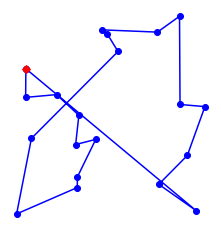

In [ ]:
print(tour_length(nn(list(ct))))
plot_tour(nn(list(ct)))

5.246416708546988


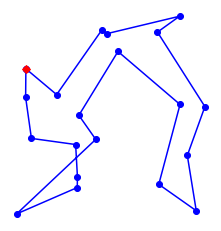

In [ ]:
print(tour_length(ni(list(ct))))
plot_tour(ni(list(ct)))

5.82506833581814


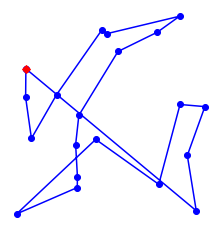

In [ ]:
print(tour_length(fi(list(ct))))
plot_tour(fi(list(ct)))

7.293683518654799


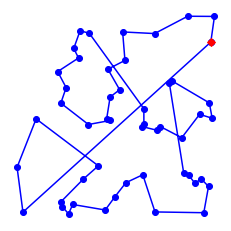

In [ ]:
print(tour_length(nn(list(ct2))))
plot_tour(nn(list(ct2)))

7.378830723247454


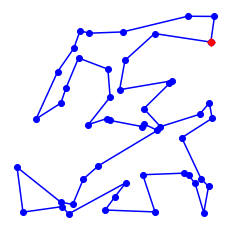

In [ ]:
print(tour_length(ni(list(ct2))))
plot_tour(ni(list(ct2)))

8.076204270930583


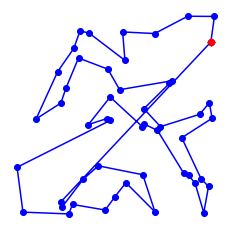

In [ ]:
print(tour_length(fi(list(ct2))))
plot_tour(fi(list(ct2)))

In [ ]:
cities_50=[]
for a in B:
  cities_50.append(complex(a[0],a[1]))

In [ ]:
ct2=frozenset(cities_50)

In [ ]:
tour_length(nn(list(ct2)))

7.293683518654799

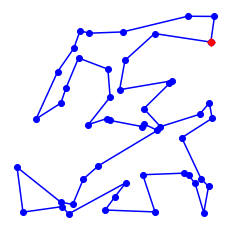

In [ ]:
plot_tour(ni(list(ct2)))

In [ ]:
tour_length(ni(list(Cities(900))))

23501.858787219066

In [ ]:
tour_length(nn(list(Cities(900))))

22174.719257763478